# Modelowanie statystyczne

> WSB-NLU, 2023-2024  
> Prowadządza: Dr hab. Elżbieta Kubińska

> Autor: Andrzej Kocielski  
> [akocielski@student.wsb-nlu.edu.pl](akocielski@student.wsb-nlu.edu.pl), [and.koc001@gmail.com](and.koc001@gmail.com)
____

## Zaimportowanie potrzebnych modułów

In [1]:
# do manipulacji ścieżkami do katalogów i plików
import os

# do obliczń numerycznych i analizy statystycznej
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels as sm
import pingouin as pg
from sklearn.linear_model import LinearRegression

# do wizualizacji danych
import matplotlib.pyplot as plt
import seaborn as sns

## Załadowanie danych surowych
Dane tygodniowe dla wybranych spółek oraz indeksów w okresie od 01.01.2023 do 15.12.2023. Źródło danych: [stooq.pl](https://stooq.pl/).

In [2]:
# Ścieżka do danych
directory_path = 'dane-finansowe'

# Lista plików csv
csv_files = [file for file in os.listdir(directory_path) if file.endswith('.csv')]

print(f"Lista plików csv:")
for i, file in enumerate(csv_files):
    print(f"{i+1}. {file}") 

Lista plików csv:
1. comarch_w.csv
2. kghm_w.csv
3. eurpln_w.csv
4. spx_w.csv
5. echo_w.csv
6. xaupln_w.csv
7. apator_w.csv
8. wig_w.csv


### Przygotowanie danych roboczych

In [3]:
# Inicjalizaja pustego DataFrame
merged_df = pd.DataFrame()

# Zaczytanie danych z poszczególnych plików csv i dodanie do wspólnego DataFrame
for file in csv_files:
    file_path = os.path.join(directory_path, file)
    df = pd.read_csv(file_path)

    # Dodanie nazwy poliku do nazwy kolumny (poza pierwszą, czyli datą)
    nazwa_pliku = os.path.splitext(os.path.basename(file))[0][:-2].upper()
    df.columns = [df.columns[0]] + [f"{col}_{nazwa_pliku}" for col in df.columns[1:]]
    
    # Łączenie danych z poszczególnych plików 
    merged_df = pd.concat([merged_df, df], ignore_index=False, axis=1)

# Usunięcie powtórzonych kolumn z datami
merged_df = merged_df.T.drop_duplicates().T


In [4]:
# Zmiana typu danych 
cols = list(merged_df.columns)
cols.remove('Data')
for col in cols:
    merged_df[col] = merged_df[col].astype(float)

merged_df['Data'] = pd.to_datetime(merged_df['Data'])

# ustawienie daty jako indeksu
merged_df.set_index('Data', inplace=True)

In [5]:
print(f"Liczba obserwacji (wierszy): {merged_df.shape[0]}, liczba kolumn: {merged_df.shape[1]}")

Liczba obserwacji (wierszy): 1094, liczba kolumn: 38


In [6]:
print(f"Podgląd kilku pierwszych wierszy:")
merged_df.head()

Podgląd kilku pierwszych wierszy:


,Otwarcie_COMARCH,Najwyzszy_COMARCH,Najnizszy_COMARCH,Zamkniecie_COMARCH,Wolumen_COMARCH,Otwarcie_KGHM,Najwyzszy_KGHM,Najnizszy_KGHM,Zamkniecie_KGHM,Wolumen_KGHM,...,Otwarcie_APATOR,Najwyzszy_APATOR,Najnizszy_APATOR,Zamkniecie_APATOR,Wolumen_APATOR,Otwarcie_WIG,Najwyzszy_WIG,Najnizszy_WIG,Zamkniecie_WIG,Wolumen_WIG
Data,,,,,,,,,,,,,,,,,,,,,
2003-01-05,28.299032,28.601199,25.000256,27.099806,431401.754479,13.652976,14.044820,13.301183,13.896453,1.489253e+06,...,18.010886,18.134605,17.537700,18.134605,6271.654193,14397.8,14795.0,14210.2,14770.5,22771651.0
2003-01-12,27.500597,28.800545,27.402089,27.801831,177222.356697,14.003914,14.301871,13.652976,14.098994,2.988803e+06,...,18.010886,18.967117,17.895054,18.851244,16115.658748,14843.8,14917.6,14569.3,14785.9,32651395.0
2003-01-19,27.998963,30.998602,26.998967,27.402089,209181.152794,14.248278,14.450818,13.855517,13.949740,2.160912e+06,...,18.609742,20.640152,18.609742,19.919384,45891.730226,14865.7,15168.0,14578.9,14637.5,31098246.0
2003-01-26,27.299035,28.500476,26.900343,27.099806,74449.211625,14.003914,14.544705,13.855517,13.855517,2.156895e+06,...,19.090816,20.282675,19.090816,20.158935,11392.844721,14594.1,14654.0,14130.4,14133.8,26306693.0
2003-02-02,26.499668,27.299035,25.701116,27.299035,99876.091811,13.599414,13.693637,12.950551,13.599414,1.384742e+06,...,20.041029,20.993460,18.967117,20.757647,12638.751694,13930.1,13984.9,13623.7,13844.8,24134712.0


In [7]:
# sprawdzamy brakujące dane (ich liczbę) w poszczególnych kolumnach 
merged_df.isnull().sum() 

Otwarcie_COMARCH      0
Najwyzszy_COMARCH     0
Najnizszy_COMARCH     0
Zamkniecie_COMARCH    0
Wolumen_COMARCH       0
Otwarcie_KGHM         0
Najwyzszy_KGHM        0
Najnizszy_KGHM        0
Zamkniecie_KGHM       0
Wolumen_KGHM          0
Otwarcie_EURPLN       0
Najwyzszy_EURPLN      0
Najnizszy_EURPLN      0
Zamkniecie_EURPLN     0
Otwarcie_SPX          0
Najwyzszy_SPX         0
Najnizszy_SPX         0
Zamkniecie_SPX        0
Wolumen_SPX           0
Otwarcie_ECHO         0
Najwyzszy_ECHO        0
Najnizszy_ECHO        0
Zamkniecie_ECHO       0
Wolumen_ECHO          0
Otwarcie_XAUPLN       0
Najwyzszy_XAUPLN      0
Najnizszy_XAUPLN      0
Zamkniecie_XAUPLN     0
Otwarcie_APATOR       0
Najwyzszy_APATOR      0
Najnizszy_APATOR      0
Zamkniecie_APATOR     0
Wolumen_APATOR        0
Otwarcie_WIG          0
Najwyzszy_WIG         0
Najnizszy_WIG         0
Zamkniecie_WIG        0
Wolumen_WIG           0
dtype: int64

___
## Interpretacja graficzna danych

In [8]:
# ogólne ustawienie stylu wykresów
# print(plt.style.available)
plt.style.use('classic')
plt.rcParams['figure.figsize'] = [12, 4]
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.size'] = 10
plt.rcParams['lines.linewidth'] = 0.75
plt.rcParams['lines.markersize'] = 1.2

### Szereg czasowy zamknięcia tygodnia

In [9]:
# przygotowanie podzbioru 
zamkniecia = ['Zamkniecie_COMARCH', 'Zamkniecie_KGHM', 'Zamkniecie_EURPLN', 'Zamkniecie_SPX', 'Zamkniecie_ECHO', 'Zamkniecie_XAUPLN', 'Zamkniecie_APATOR', 'Zamkniecie_WIG']
zamkniecia_df = merged_df[zamkniecia]

spolki = ['Zamkniecie_COMARCH', 'Zamkniecie_KGHM', 'Zamkniecie_ECHO', 'Zamkniecie_APATOR']
spolki_df = merged_df[spolki]

### Zmienność wartości spółek w badanym okresie

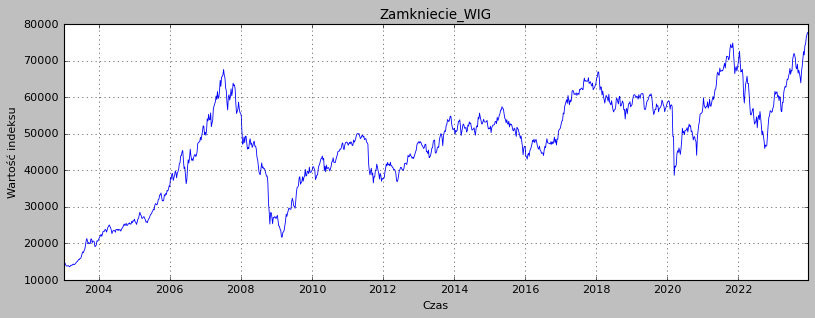

In [10]:
# wartość indeksu WIG w badanym okrecie
walor = zamkniecia_df.columns[-1] 

# dane
plt.plot(zamkniecia_df[walor]) 

plt.title(f'{walor}')
plt.xlabel('Czas')
plt.ylabel('Wartość indeksu')
plt.grid(True, linestyle='dotted')

plt.show()

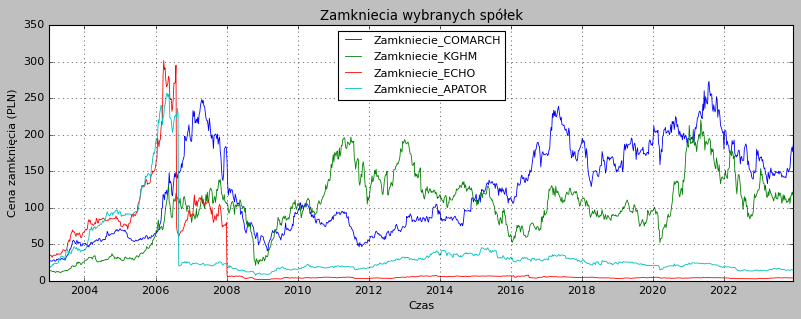

In [11]:
# wartość danego waloru w badanym okrecie
for walor in range(len(spolki_df.columns)):
    plt.plot(zamkniecia_df[spolki_df.columns[walor]], label=spolki_df.columns[walor]) 

plt.title(f'Zamkniecia wybranych spółek')
plt.xlabel('Czas')
plt.ylabel('Cena zamknięcia (PLN)')
plt.grid(True,linestyle='dotted') 
plt.legend(fontsize='10', loc='upper center')

plt.show()

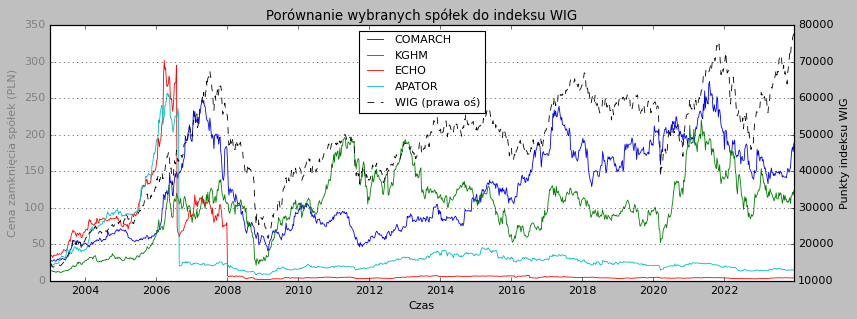

In [12]:
# porównanie wybranych spółek do indeksu WIG

# Create the first plot
fig, ax1 = plt.subplots()

# Plot the first dataset on the lebt y-axis
for walor in range(len(spolki_df.columns)):
    ax1.plot(zamkniecia_df[spolki_df.columns[walor]], linestyle='-', label=spolki_df.columns[walor][11:]) 
ax1.set_xlabel('Czas')
ax1.set_ylabel('Cena zamknięcia spółek (PLN)', color='grey')
ax1.tick_params('y', colors='grey')

# Create the second plot sharing the same x-axis
ax2 = ax1.twinx()

# Plot the second dataset on the right y-axis
wig = zamkniecia_df.columns[-1]
ax2.plot(zamkniecia_df[wig], color='black', linestyle='--', label=f'{wig[11:]} (prawa oś)')
ax2.set_ylabel('Punkty indeksu WIG', color='black')
ax2.tick_params('y', colors='black')

# Show the plots
plt.title(f'Porównanie wybranych spółek do indeksu WIG')
lines, labels = ax1.get_legend_handles_labels()
lines_wig, labels_wig = ax2.get_legend_handles_labels()
ax2.legend(lines + lines_wig, labels + labels_wig, fontsize='10', loc='upper center')
plt.grid(True, linestyle='dotted') 
plt.show()

___
## Statystyka opisowa
### Dla spółki Comarch (jako przykład)

In [13]:
comarch_cols = ["Zamkniecie_COMARCH", "Wolumen_COMARCH"]

### Wybrane miary zmienności
- Rozstęp
- Odchylenie ćwiartkowe
- Wariancja
- Odchylenie standardowe
- Współczynnik zmienności

### Wybrane miary pozycyjne
- Średnia
- Kwantyle
- Mediana (kwantyl 50%)
- Moda

### Wybrane miary kształtu
- Skośność
- Kurtoza

In [14]:
# Przygotowanie parametrów statystycznych

# własna funkcja do obliczania inter quartile range (IQR)
def q25(column):
    return column.quantile(0.25)
def q75(column):
    return column.quantile(0.75)    
def IQR(column): 
    q25, q75 = column.quantile([0.25, 0.75])
    return q75-q25

# własna funkcja do obliczania zakresu
def range_max_min(column):
    return column.max() - column.min()

# własna funkcja do obliczania współczynnika zmienności (coefficient of variance)
def cv(column):
    return stats.variation(list(column)) * 100

# własna funkcja do wyznaczania błędu standardowego
def sem(column):
    return stats.sem(list(column))

# własna funkcja do wyznaczenia przedziału ufności dla średniej
def ci(column):
    conf_level = 0.95
    df = len(column) - 1
    sem = stats.sem(list(column))
    # return stats.t.interval(conf_level, df, np.mean(column), sem)

    lower, upper = stats.t.interval(conf_level, df, np.mean(column), sem)
    lower = round(lower, 3)
    upper = round(upper, 3)
    return lower, upper

charakterystyka = ["min", q25, "mean", "median", q75, IQR, "max", range_max_min, "var", "std", cv, sem, ci, "skew", "kurtosis"]

In [15]:
merged_df[comarch_cols].agg(charakterystyka)

,Zamkniecie_COMARCH,Wolumen_COMARCH
min,26.998967,414.209002
q25,69.999972,8167.88004
mean,124.790129,31502.620402
median,117.210668,16970.808795
q75,175.999543,36870.601798
IQR,105.999572,28702.721758
max,272.999654,431401.754479
range_max_min,246.000687,430987.545477
var,3496.816984,1853908016.174635
std,59.13389,43057.032134


### Interpretacja wybranych statystyk dla _cen zamknięcia_ akcji Comarch w interwałach tygodniowych

$min$ -> najniższa cena akcji Comarch na zamknięciu tygodniowym w obserwowanym okresie

$max$ -> najwyższa cena akcji na zamknięciu tygodniowym 

$mean$ -> średnia arytmetyczna cen zamknięcia

$median$ -> mediana (wartość środkowa); wartość mniejsza od średniej wskazuje na skośność statystyki

$std$ -> odchylenie standardowe wyrażone w PLN; stosunkowo duża wartość $std$ w stosunku do średniej wskazuje na znaczny rozrzut zmiennej 

$cv$ -> współczynnik zmienności; średnia / odchylenie standardowe

$sem$ -> błąd standardowy średniej; rozrzut estymatorów z próby wokół parametru populacji, czyli jak bardzo średnia próbki jest "rozmyta" (miara niepewności testu)

$ci$ -> przedział ufności; z prawdopodobieństwem 0.95 prawdziwa wartość parametru populacyjnego (średnia cen zamknięcia) znajduje się w tym przedziale

$skew$ -> skośność; wartość większa od 1 świadczy o skośności lewostronnej

$kurtosis$ -> kurtoza; bada czy rozkład jest płaski, czy stromy; kurtoza < 0 wskazuje na rozkład platykurtyczny, czyli rozkład niski i szeroki (Wartości zmiennej są bardziej rozrzucone wokół średniej oraz mamy mniejsze prawdopodobieństwo wystąpienia wartości ekstremalnych)


___
## Analiza kursu EUR - PLN
### Histogram

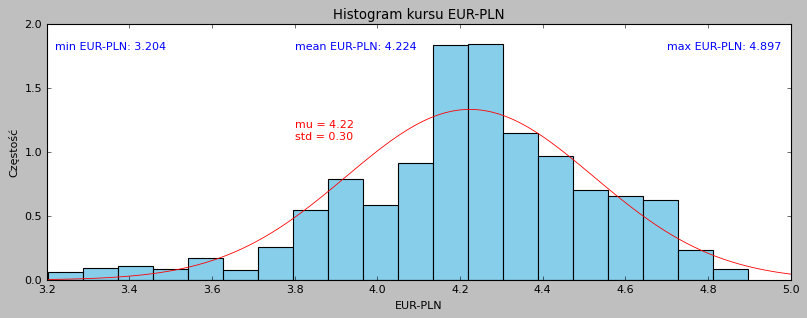

In [16]:
# Utwórzenie histogram
plt.hist(merged_df["Zamkniecie_EURPLN"], bins=20, density=True, color='skyblue')

# Wykreślenie krzywej gęstości prawdopodobieństwa (pdf)
mu, std = stats.norm.fit(merged_df["Zamkniecie_EURPLN"])
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, mu, std)
plt.plot(x, p, 'r')

# Opis wykresu i osi

# Customize the plot
plt.title('Histogram kursu EUR-PLN')
plt.xlabel('EUR-PLN')
plt.ylabel('Częstość')
plt.text(3.22, 1.8, f'min EUR-PLN: {np.min(merged_df["Zamkniecie_EURPLN"]):.3f}', color='b')
plt.text(4.7, 1.8, f'max EUR-PLN: {np.max(merged_df["Zamkniecie_EURPLN"]):.3f}', color='b')
plt.text(3.8, 1.8, f'mean EUR-PLN: {np.mean(merged_df["Zamkniecie_EURPLN"]):.3f}', color='b')
plt.text(3.8, 1.1, f'mu = {mu:.2f} \nstd = {std:.2f}', color='r')
plt.show()

# Show the plot
plt.show()

Rozkład z grubsza przypomina normalny, choć nie-symetryczny i rozciągnięty. Porwónajmy zatem niektóre parametry rozkładu.

In [17]:
print(f'{merged_df["Zamkniecie_EURPLN"].describe().to_string()}')
print(f'skew \t   {stats.skew(merged_df["Zamkniecie_EURPLN"]):.6f}')
print(f'kurtosis    {stats.kurtosis(merged_df["Zamkniecie_EURPLN"]):.6f}')

count    1094.000000
mean        4.223629
std         0.299397
min         3.203800
25%         4.069725
50%         4.238680
75%         4.420037
max         4.896750
skew 	   -0.547283
kurtosis    0.620155


### Wyznaczenie trzech sigm dla cen zamknięcia EUR-PLN

In [18]:
# Dystrybuanta dla cen zamknięcia EUR-PLN
mean =  np.mean(merged_df["Zamkniecie_EURPLN"])
std_dev = np.std(merged_df["Zamkniecie_EURPLN"], ddof=1)

# Wartości Z-score dla trzech odchyleń standardowych
z_scores = [-3, -2, -1, 1, 2, 3]

print(f'Średnia: {mean:.4f}')
print(f'Odchylenie standardowe: {std_dev:.4f}')

# Oblicz dystrybuantę dla odchyleń standardowych (wartość Z-score)
sigmy = [z * std_dev + mean for z in z_scores]
for z in sigmy:
    cumulative_probability = stats.norm.cdf(z, loc=mean, scale=std_dev)
    print(f'Dystrybuanta dla {z:.4f} ({(z-mean)/std_dev:.0f} sigma): {cumulative_probability:.4f}')

Średnia: 4.2236
Odchylenie standardowe: 0.2994
Dystrybuanta dla 3.3254 (-3 sigma): 0.0013
Dystrybuanta dla 3.6248 (-2 sigma): 0.0228
Dystrybuanta dla 3.9242 (-1 sigma): 0.1587
Dystrybuanta dla 4.5230 (1 sigma): 0.8413
Dystrybuanta dla 4.8224 (2 sigma): 0.9772
Dystrybuanta dla 5.1218 (3 sigma): 0.9987


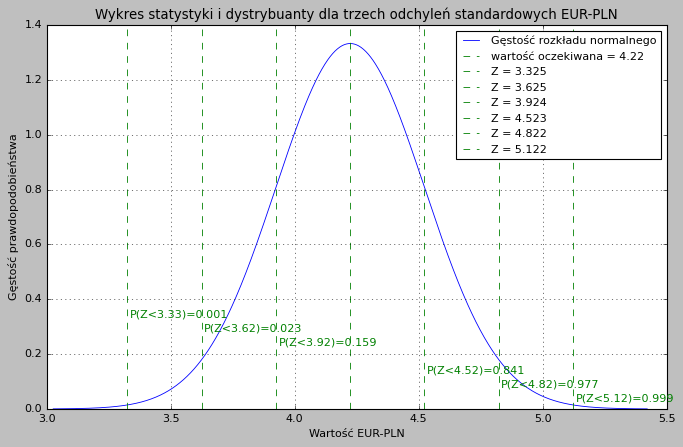

In [19]:
# Analiza graficzna trzech sigm

# Tworzenie danych dla osi X (wartości Z-score)
x_values = np.linspace(mean - 4 * std_dev, mean + 4 * std_dev, 1000)

# Tworzenie wykresu statystyki
plt.figure(figsize=(10, 6))
plt.plot(x_values, stats.norm.pdf(x_values, loc=mean, scale=std_dev), label='Gęstość rozkładu normalnego')

# wartość oczekiwana
plt.axvline(mean, color='g', linestyle='--', label=f'wartość oczekiwana = {mean:.2f}')

# Dodanie dystrybuant dla różnych odchyleń standardowych
for z in sigmy:
    plt.axvline(z, color='g', linestyle='--', label=f'Z = {z:.3f}')

    # Obliczanie dystrybuanty dla danego Z-score
    cumulative_probability = stats.norm.cdf(z, loc=mean, scale=std_dev)
    plt.text(.01+z, .9+z*-.17, f'P(Z<{z:.2f})={cumulative_probability:.3f}', color='g')

# Konfiguracja wykresu
plt.title('Wykres statystyki i dystrybuanty dla trzech odchyleń standardowych EUR-PLN')
plt.xlabel('Wartość EUR-PLN')
plt.ylabel('Gęstość prawdopodobieństwa')
plt.legend(fontsize='10')
plt.grid(True)
plt.show()

___
## Testy statystyczne
### Czy częstość występowania cen EUR-PLN ma rozkład normalny

In [20]:
# Test Kołmogorowa-Smirnowa
statistic, p_value = stats.kstest(merged_df['Zamkniecie_EURPLN'], 'norm')
print("Statystyka testowa:", statistic)
print("Wartość p:", p_value)

# Interpretacja wyników
alpha = 0.05
if p_value > alpha:
    print("Wniosek: nie ma podstaw do odrzucenia hipotezy zerowej (o normalności rozkładu).")
else:
    print("Wniosek: odrzucono hipotezę zerową na korzyść hipotezy alternatywnej (nie normalny rozklad).")

Statystyka testowa: 0.9993218667162591
Wartość p: 0.0
Wniosek: odrzucono hipotezę zerową na korzyść hipotezy alternatywnej (nie normalny rozklad).


In [21]:
# Test D'Agostino i Pearson:
statistic, p_value = stats.normaltest(merged_df['Zamkniecie_EURPLN'])

print("Statystyka testowa:", statistic)
print("Wartość p:", p_value)

# Interpretacja wyników
alpha = 0.05
if p_value > alpha:
    print("Wniosek: nie ma podstaw do odrzucenia hipotezy zerowej (rozklad normalny).")
else:
    print("Wniosek: odrzucono hipotezę zerową na korzyść hipotezy alternatywnej (nie normalny rozklad).")

Statystyka testowa: 60.17132120784457
Wartość p: 8.589415573446294e-14
Wniosek: odrzucono hipotezę zerową na korzyść hipotezy alternatywnej (nie normalny rozklad).


___
## Analiza portfelowa
Na przykładzie cen zamknięcia spółki Comarch wobec indeksu WIG

### Wyznaczenie korelacji

In [22]:
# Dane (zmienne niezależne i zależna)
x = merged_df['Zamkniecie_WIG']
y = merged_df['Zamkniecie_COMARCH']

# Obliczenie współczynnika korelacji (Pearson)
correlation_coefficient = np.corrcoef(x, y)[0, 1]
# Wyświetlenie współczynnika korelacji
print(f'Współczynnik korelacji: {correlation_coefficient:.2f}')

Współczynnik korelacji: 0.80


### Model regresji liniowej

Współczynnik nachylenia (a): [0.73127588]
Wyraz wolny (b): [0.00144535]
Współczynnik determinacji (R^2): 0.1844239019603393


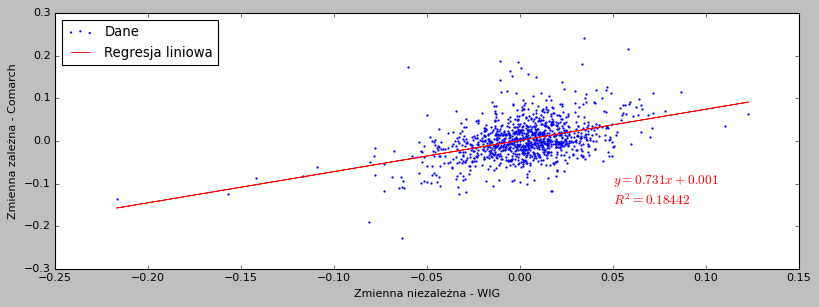

In [23]:
# Przekształcenie elementów serii, tak aby uzyskać procentową zmianę między elementami, tj. (bierzący/poprzedni - 1) 
x = merged_df['Zamkniecie_WIG'].pct_change().dropna()
y = merged_df['Zamkniecie_COMARCH'].pct_change().dropna()  

# Przekształcenie danych do postaci wymaganej przez scikit-learn
X = x.values.reshape(-1, 1)
y = y.values.reshape(-1, 1)

# Inicjalizacja modelu regresji liniowej
model = LinearRegression()

# Dopasowanie modelu do danych
model.fit(X, y)

# Wyświetlenie wyników regresji
print("Współczynnik nachylenia (a):", model.coef_[0])
print("Wyraz wolny (b):", model.intercept_)
print("Współczynnik determinacji (R^2):", model.score(X, y))

# Dodanie równania regresji liniowej na wykresie
equation = f'$y = {float(model.coef_[0]):.3f}x + {float(model.intercept_):.3f}$'
plt.annotate(equation, xy=(0.05, -.1), fontsize=12, color='red')
r = f'$R^2 = {model.score(X, y):.5f}$'
plt.annotate(r, xy=(0.05, -.15), fontsize=12, color='red')

# Wykres danych i regresji
plt.scatter(x, y, color='blue', label='Dane', s=1)
plt.plot(x.values.reshape(-1, 1), model.predict(X), color='red', label='Regresja liniowa')
plt.xlabel('Zmienna niezależna - WIG')
plt.ylabel('Zmienna zależna - Comarch')
plt.legend(loc='upper left')
# plt.xlim(10000, 80000) 
# plt.ylim(0, 300)
plt.show()

Interpretacja:
- Ponieważ współczynnik kierunkowy jest różny od zera (w stopniu 'na oko' wystarczająco istotnym - do sprawdzenia), oraz dodatni, istnieje dodatnia korelacja między cenami spółki Comarch i wartościami indeksu WIG.
- Wyraz wolny jest bardzo bliski zeru (do sprawdzenia czy istotnie bliski), zatem zachowanie cen spółki Comarch sugeruje bliskie odwzorowanie zachowania indeksu WIG (ani systematycznie nie bije rynku, ani systematycznie nie przegrywa z rynkiem).

___
## Dodatkowe źródła
- [https://mateuszgrzyb.pl/3-metody-analizy-normalnosci-rozkladu-w-python/](https://mateuszgrzyb.pl/3-metody-analizy-normalnosci-rozkladu-w-python/)
- [https://github.com/bilalonur/financial-visualization/blob/main/finance-visualization.ipynb](https://github.com/bilalonur/financial-visualization/blob/main/finance-visualization.ipynb)
- [https://python.cogsci.nl/numerical/statistics/](https://python.cogsci.nl/numerical/statistics/)
- [https://pingouin-stats.org/](https://pingouin-stats.org/)
- [https://www.naukowiec.org/wiedza/statystyka/](https://www.naukowiec.org/wiedza/statystyka/)

___
Andrzej Kocielski, 2024